In [7]:
import pandas as pd
import spacy 
nlp = spacy.load('en')

SyntaxError: invalid syntax (<ipython-input-7-393f0df601c1>, line 3)

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter 
from bs4 import BeautifulSoup 
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
stop = set(stopwords.words('english'))

import pickle

def dump(obj,filename):
    filehandler = open(filename,"wb")
    pickle.dump(obj,filehandler)
    filehandler.close()

def load(filename):
    file = open(filename,'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Preprocessing

In [3]:
# READS THE EXCEL FILE
# INSTEAD OF FILE, WE SHOULD BE PASSING DATAFRAMES (FOR THE SELECTION OF SOURCES)
conversations = pd.read_excel('Coke vs Pepsi Twitter Data for NLP 1.xlsx')

NameError: name 'pd' is not defined

In [5]:
# DROPS THE EMPTY OBSERVATIONS. ARE WE SUPPOSED TO DO THAT IN THIS CASE? THERE ARE NO BLANK TEXTS IN THIS SET
conversations = conversations.dropna(subset=['Sound Bite Text'])

#### Function to Clean Text used later

In [32]:
# CLEANS TEXT BY REPLACING CHARACTERS
def getCleanText(text, lower = True):
    text = str(text)
    parse_text = BeautifulSoup(text).get_text()
    
    letters_only = re.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' url ', 
                          parse_text, flags=re.MULTILINE)
    letters_only = re.sub('^(1?[0-9]|2[0-3]):[0-5][0-9]$','time',letters_only)
    letters_only = re.sub('(name|NAME)\d{1,}','username',letters_only)
    
    
    letters_only = re.sub("[^a-zA-Z0-9\.:']",  
                      " ",                   
                      letters_only)
    letters_only = letters_only.replace('\n'," ")
    letters_only = letters_only.replace('\r'," ")
    letters_only = re.sub('[.]{2,}', '. ', letters_only)
    
    
    if lower:
        letters_only = letters_only.lower()
  
    
    
    #words = word_tokenize(lower)
    words = CountVectorizer(stop_words='english').build_tokenizer()(letters_only)
    
    
    meaningful_words = [ w for w in words if len(w)> 0 and len(w)<20]
    
    
    #meaningful_words = [w if (w not in countries) and (w not in cities) else u"country" for w in meaningful_words]
    #lem_words = [wordnet_lemmatizer.lemmatize(w) for w in  meaningful_words]
    #stem_words = [snowball_stemmer.stem(w) for w in lem_words]
    
    
    
    clean_text = " ".join(meaningful_words)

    return clean_text

In [7]:
#define some parameters  
noisy_pos_tags = ['PROP'] # TAGGING OF PROP
min_token_length = 2 # TWO CHARACTERS OR TWO TOKENS?

#Function to check if the token is a noise or not  
def isNoise(token):     
    is_noise = False
    if token.pos_ in noisy_pos_tags: # FROM LIST ABOVE
        is_noise = True 
    elif token.is_stop == True: # FROM STOP WORDS LIST 
        is_noise = True
    elif len(token.string) <= min_token_length: # FROM PARAMETER ABOVE
        is_noise = True
    return is_noise 
def cleanup(token, lower = True):
    if lower: # TURNS ALL TEXT TO LOWERCASE
        token = token.lower()
    return token.strip() # REMOVES SPACES FROM THE BEGINNING AND END

### Named Entity Recognition

In [60]:
# look for common used tags
def get_entities(sent):
    sentence = sent
    try:
        document = nlp(sentence)
    except:
        return ["error"]
    
    entities_list = document.ents
    labels2 = list(w.label_ for w in document.ents) 
#    labels = set([w.label_ for w in document.ents]) 
#     for label in labels: 
#         entities = [cleanup(e.string, lower=False) for e in document.ents if label==e.label_] 
#         entities = list(set(entities))
#         #Here Labels is ORG if you dont specify this it will give you all entities which we want, 
#         #keep the labels as well to explore
#         if label == "ORG": # I HAVE TO PLAY WITH THESE LABELS TO EXTRACT THE CORRECT ENTITIES
#             entities_list.append(entities)
#     if len(entities_list) > 0:
#         return entities_list
#     else:
#         return ["<UNK>"]
    return labels2

org_list= map(get_entities, conversations["Sound Bite Text"][:20000]) #NAMED entity rowwise # I DO NOT GET THIS LINE

In [2]:
def get_entities(sent):
    #sentence = unicode(sent.decode('utf8'))
    sentence = sent#.decode('utf8')
    try:
        document = nlp(sentence)
    except:
        return ["error"]
    
    entities_list = []
    labels = set([w.label_ for w in document.ents]) 
    for label in labels: 
        entities = [cleanup(e.string, lower=False) for e in document.ents if label==e.label_] 
        entities = list(set(entities))
        #Here Labels is ORG if you dont specify this it will give you all entities which we want, 
        #keep the labels as well to explore
        if label == "ORG": # I HAVE TO PLAY WITH THESE LABELS TO EXTRACT THE CORRECT ENTITIES
            entities_list.append(entities)
    if len(entities_list) > 0:
        return entities_list
    else:
        return ["<UNK>"]

org_list = map(get_entities, conversations["Sound Bite Text"][:2000]) #NAMED entity rowwise # I DO NOT GET THIS LINE
print(list(org_list))

NameError: name 'conversations' is not defined

In [66]:
def clean_org(org_list):
    #org = list(filter(lambda x: "XX" not in x , org_list))
    org = list(filter(lambda x: "<UNK>" not in x, org_list))
    return org

clean_org_list = map(clean_org, org_list)

#### Concatentate Named Entities together from all rows

In [67]:
all_orgs = []
for orgs in clean_org_list:
    if orgs == '<UNK>':
        orgs = [orgs]
    all_orgs+=orgs
print(type(all_orgs))
print(all_orgs)

<class 'list'>
[['🍔and a Diet Coke'], ['Coke', 'Scotch Whisky', 'Zero Sugar', 'Coca-Cola'], ['Coca-Cola Bottling Co.'], ['Sugar', 'Warmth\n Energy', 'Diet', 'Taste\n Food'], ['Pepsi-Cola', 'Playboy'], ['Britney, Beyonce'], ['Coke'], ['Pepsi'], ['AskarUpahan'], ['Beyoncé', 'Super Bowl', 'Pepsi’s', 'BritneySpears'], ['Pepsi'], ['PEPSI'], ['Coca Cola Zero'], ['Coca-Cola'], ['Pepsi', 'Mojo'], ['Coca-Cola Product', 'Rolls', 'Cheez-It Baked Snack Crackers', 'Stuffed Nachos', 'Blasted Crust Rolls', "Totino's", 'Keebler Chips Deluxe Cookies', 'Grooves Cracker Chips', 'Coca-Cola', 'Pizza Sticks', 'Totino’s Pizza Rolls', '9/29/17 (Publix Coupon Green Grocery Flyer'], ['Pepsi'], ['This Social Justice Warrior', 'NFL', 'Pepsi', 'Apple', 'UA'], ['Pepsi', 'Coke', 'Amazed Velcro'], ['Supermarkets, Dollar', 'Convenience Stores', 'Coca Cola', 'Drug', 'Ikea, Liquor'], ['Patriots'], ['Motown', 'Joy of Cola', 'Betty Inc.', 'Super Bowl', 'Pepsi', 'R&B', 'PepsiCo Inc.'], ['Pepsi', 'the Second Circuit', 'the 

In [68]:
all_orgs_clean = map(getCleanText, all_orgs)
#print(list(all_orgs_clean))

#### Count of Named Entitites

In [69]:
banks_dict = Counter(all_orgs_clean)
banks_list_sorted = sorted(banks_dict, key = banks_dict.get, reverse=True)
banks_list_sorted_tup = [(bank,banks_dict[bank]) for bank in banks_list_sorted]
banks_list_sorted_tup

/Users/erikdaily/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/erikdaily/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


[('coca cola', 1690),
 ('pepsi', 1287),
 ('beyonc super bowl pepsi britneyspears', 521),
 ('coke', 442),
 ('pepsi black', 344),
 ('mcdonalds pepsi apocalypse chrtistians', 300),
 ('coca', 283),
 ('pepsi coke', 181),
 ('coke coca cola', 146),
 ('chocolate coca coca cola', 68),
 ('coca cola company', 60),
 ('un rt', 57),
 ('pepsi bernie boston', 46),
 ('britney beyonce', 45),
 ('diet', 45),
 ('the chicago cubs coca cola auschwitz', 39),
 ('pepsi coca cola', 37),
 ('nfl', 36),
 ('pepsi fan party', 35),
 ('oovoo ramones the dominos', 32),
 ('coca cola coke', 31),
 ('pepsi nfl', 29),
 ('diet coke', 28),
 ('pepsi 10', 28),
 ('nestle nestle pepsico coca cola pepsi coke', 27),
 ('pepsi pepsico', 26),
 ('pepsi beyonc', 26),
 ('coca cola company coca cola', 25),
 ('the world of coca cola cuisine of the brooklyn indie outkast the georgia aquarium 160 tourism main',
  24),
 ('really', 23),
 ('wilkinson student center byu coke zero sugar', 22),
 ('coca cola coca cola', 21),
 ('norfolk southern hart

In [56]:
dump(banks_list_sorted_tup, "bank_counts.pkl")

In [57]:
banks = map(lambda x:x[0] , banks_list_sorted_tup)
banks_count = map(lambda x: x[1], banks_list_sorted_tup)

In [58]:
banks_count_df = pd.DataFrame(data = banks_list_sorted_tup)
banks_count_df.size
#banks_count_df.columns = ["Bank_Name", "Count"]

112

ValueError: Could not interpret input 'Bank_Name'

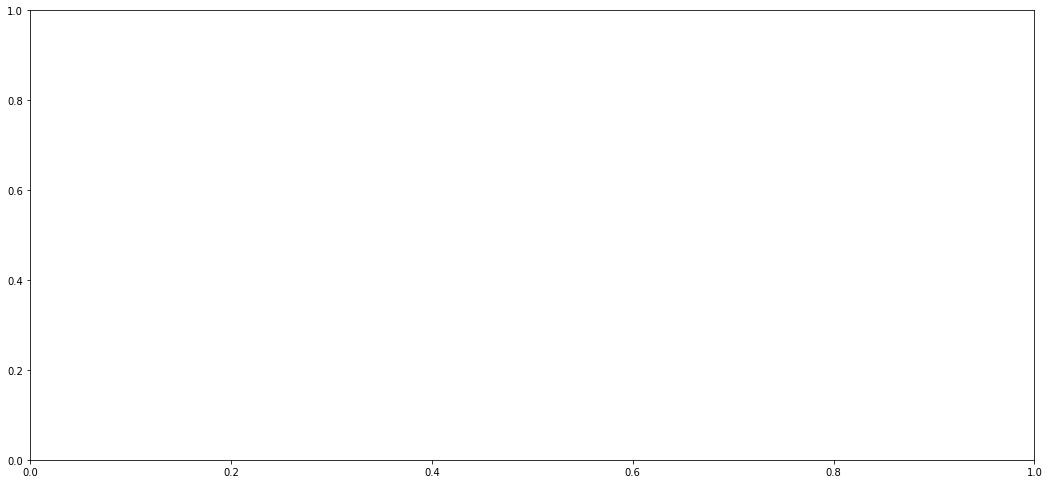

In [59]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(18, 8.27)
ax = sns.barplot(x="Bank_Name", y="Count", data = banks_count_df[1:100])
_ = plt.xticks(rotation=90)

In [ ]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(18, 8.27)
ax = sns.barplot(x="Bank_Name", y="Count", data = banks_count_df[1:100])
_ = plt.xticks(rotation=90)